<a id="top"></a>
# Classifying Pan-STARRS sources with unsupervised and supervised learning

***

## Learning Goals


**In this tutorial, you will see an example of using models to classify sources extracted from astronomical data.**  By the end of this tutorial you will have working examples of how to apply principal component analysis (PCA), t-distributed stochastic neighbor embedding (tSNE), k-means clustering (unsupervised learning) and stochastic gradient descent (SGD) classification (supervised learning).

## Introduction

Machine learning which can be applied in both supervised and unsupervised contexts for classification. In this notebook, we will walk through the basic steps of reducing the dimensionality of astronomical source catalogs with PCA and tSNE and classifying the sources in unsupervised and supervised formats.

1. Download and import the data
2. Perform data cleaning steps
3. Reduce dimensionality with PCA and tSNE
4. Perform unsupervised clustering with k-means
5. Perform supervised classification with SGD
6. Assess the success of the model with a confusion matrix

Here we will classify sources extracted from multi-wavelength photometry from the [Pan-STARRS](https://outerspace.stsci.edu/display/PANSTARRS/) survey, and compare with previous classifications from a convolutional neural network analysis by the [PS1-STRM](https://archive.stsci.edu/hlsp/ps1-strm) team.


## Imports
This notebook uses the following:
- `numpy` to handle array functions
- `astropy` for accessing FITS files
- `matplotlib.pyplot` for plotting data
- `sklearn` for models and performance metrics
- `itertools` for generating combinations
- `scipy` for statistics

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table

# Plotting
import matplotlib.pyplot as plt

# sklearn for performance metrics

# sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# iterative combinations
from itertools import combinations

# statistics 
import scipy.stats as st

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

### 1. Download the data

For the following exercises, we will use data from the Pan-STARRS1 (PS1) catalog, which includes wide-area imaging in five wavelength bands, g, r, i, z  and y.

Using convolutional neural networks (CNNs) trained on spectroscopic surveys, the Pan-STARRS1 Source Types and Redshifts with Machine Learning (PS1-STRM) ([Beck et al. 2020](https://dx.doi.org/10.1093/mnras/staa2587)) team classified ("star", "galaxy", "QSO" and "unsure") and regressed redshift information for the 2,902,054,648 discree sources in the [PS1 3$\pi$ DR1 catalog](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Source+extraction+and+catalogs). This volume of data is far too large to analyze in a short notebook example. Therefore, we extracted a subset of PS1-STRM and cross-matched it with the PS1 catalog (see Appendix for details on how to obtain this subset from MAST). 

This subset of PS1 will be used to test whether simple clustering algorithms can reproduce the classification results of PS1-STRM.  The dataset consists of 100,000 sources, randomly selected to have roughly equal representation in the four PS1-STRM classes. 

First, load the data into an `astropy` table:

In [2]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_ps1strm_subset.fits'
tab = Table.read(download_file(file_url, cache=True))

CPU times: user 617 ms, sys: 343 ms, total: 960 ms
Wall time: 2.54 s


Inspect the contents of the table:

In [3]:
tab

class,prob_Galaxy,prob_Star,prob_QSO,z_phot,z_photErr,objID,uniquePspsFOid,ippObjID,randomForcedObjID,nDetections,batchID,processingVersion,gnTotal,gnIncPSFFlux,gnIncKronFlux,gnIncApFlux,gnIncR5,gnIncR6,gnIncR7,gFPSFFlux,gFPSFFluxErr,gFPSFFluxStd,gFPSFMag,gFPSFMagErr,gFKronFlux,gFKronFluxErr,gFKronFluxStd,gFKronMag,gFKronMagErr,gFApFlux,gFApFluxErr,gFApFluxStd,gFApMag,gFApMagErr,gFmeanflxR5,gFmeanflxR5Err,gFmeanflxR5Std,gFmeanflxR5Fill,gFmeanMagR5,gFmeanMagR5Err,gFmeanflxR6,gFmeanflxR6Err,gFmeanflxR6Std,gFmeanflxR6Fill,gFmeanMagR6,gFmeanMagR6Err,gFmeanflxR7,gFmeanflxR7Err,gFmeanflxR7Std,gFmeanflxR7Fill,gFmeanMagR7,gFmeanMagR7Err,gFlags,gE1,gE2,rnTotal,rnIncPSFFlux,rnIncKronFlux,rnIncApFlux,rnIncR5,rnIncR6,rnIncR7,rFPSFFlux,rFPSFFluxErr,rFPSFFluxStd,rFPSFMag,rFPSFMagErr,rFKronFlux,rFKronFluxErr,rFKronFluxStd,rFKronMag,rFKronMagErr,rFApFlux,rFApFluxErr,rFApFluxStd,rFApMag,rFApMagErr,rFmeanflxR5,rFmeanflxR5Err,rFmeanflxR5Std,rFmeanflxR5Fill,rFmeanMagR5,rFmeanMagR5Err,rFmeanflxR6,rFmeanflxR6Err,rFmeanflxR6Std,rFmeanflxR6Fill,rFmeanMagR6,rFmeanMagR6Err,rFmeanflxR7,rFmeanflxR7Err,rFmeanflxR7Std,rFmeanflxR7Fill,rFmeanMagR7,rFmeanMagR7Err,rFlags,rE1,rE2,inTotal,inIncPSFFlux,inIncKronFlux,inIncApFlux,inIncR5,inIncR6,inIncR7,iFPSFFlux,iFPSFFluxErr,iFPSFFluxStd,iFPSFMag,iFPSFMagErr,iFKronFlux,iFKronFluxErr,iFKronFluxStd,iFKronMag,iFKronMagErr,iFApFlux,iFApFluxErr,iFApFluxStd,iFApMag,iFApMagErr,iFmeanflxR5,iFmeanflxR5Err,iFmeanflxR5Std,iFmeanflxR5Fill,iFmeanMagR5,iFmeanMagR5Err,iFmeanflxR6,iFmeanflxR6Err,iFmeanflxR6Std,iFmeanflxR6Fill,iFmeanMagR6,iFmeanMagR6Err,iFmeanflxR7,iFmeanflxR7Err,iFmeanflxR7Std,iFmeanflxR7Fill,iFmeanMagR7,iFmeanMagR7Err,iFlags,iE1,iE2,znTotal,znIncPSFFlux,znIncKronFlux,znIncApFlux,znIncR5,znIncR6,znIncR7,zFPSFFlux,zFPSFFluxErr,zFPSFFluxStd,zFPSFMag,zFPSFMagErr,zFKronFlux,zFKronFluxErr,zFKronFluxStd,zFKronMag,zFKronMagErr,zFApFlux,zFApFluxErr,zFApFluxStd,zFApMag,zFApMagErr,zFmeanflxR5,zFmeanflxR5Err,zFmeanflxR5Std,zFmeanflxR5Fill,zFmeanMagR5,zFmeanMagR5Err,zFmeanflxR6,zFmeanflxR6Err,zFmeanflxR6Std,zFmeanflxR6Fill,zFmeanMagR6,zFmeanMagR6Err,zFmeanflxR7,zFmeanflxR7Err,zFmeanflxR7Std,zFmeanflxR7Fill,zFmeanMagR7,zFmeanMagR7Err,zFlags,zE1,zE2,ynTotal,ynIncPSFFlux,ynIncKronFlux,ynIncApFlux,ynIncR5,ynIncR6,ynIncR7,yFPSFFlux,yFPSFFluxErr,yFPSFFluxStd,yFPSFMag,yFPSFMagErr,yFKronFlux,yFKronFluxErr,yFKronFluxStd,yFKronMag,yFKronMagErr,yFApFlux,yFApFluxErr,yFApFluxStd,yFApMag,yFApMagErr,yFmeanflxR5,yFmeanflxR5Err,yFmeanflxR5Std,yFmeanflxR5Fill,yFmeanMagR5,yFmeanMagR5Err,yFmeanflxR6,yFmeanflxR6Err,yFmeanflxR6Std,yFmeanflxR6Fill,yFmeanMagR6,yFmeanMagR6Err,yFmeanflxR7,yFmeanflxR7Err,yFmeanflxR7Std,yFmeanflxR7Fill,yFmeanMagR7,yFmeanMagR7Err,yFlags,yE1,yE2
bytes6,float64,float64,float64,float64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64

### 2. Clean the data

As our interest is to classify the sources, we first "encode" the PS1-STRM classifications from string values to integers:

In [4]:
label_encoder = LabelEncoder()
tab['class_encode'] = label_encoder.fit_transform(tab['class'])

Next, we will select a subset of the table, specifically the "FPSFMag" magnitude values for the five PS1 bands (g, r, i z, and y). Following the strategy of [Beck et al. 2020](https://dx.doi.org/10.1093/mnras/staa2587), we will normalize these magnitudes by subtracting the median. Then, we will impute missing values by setting them equal to the median. **NOTE** this may be a risky move! An alternative strategy is to simply remove the missing values from the training set, or to impose an *N*-$\sigma$ limit. 

In [5]:
bands = ['g', 'r', 'i', 'z', 'y']
tt = 'FPSFMag'

tags_f = np.ravel([[b+tt] for b in bands])
fluxes = [tab[tag] for tag in tags_f]
for k in range(len(tags_f)):
    fluxes[k] = fluxes[k] - np.median(fluxes[k]) 
    
    fluxes[k] = np.where(fluxes[k] < -100, np.median(fluxes[k]), fluxes[k])
    fluxes[k] = np.where(fluxes[k] > 100, np.median(fluxes[k]), fluxes[k])

In addition to measured fluxes, we will add galaxy colors to the sample. For the unique combinations of filters we will compute colors. As for the fluxes, we normalize by subtracting the medians, and then all missing values are set to the medians as above (but see note!).

In [6]:
combos = list(combinations(bands, 2))
colors = []
tags_c = []
for c in list(combos): 
    color = np.array(tab[c[0]+tt]-tab[c[1]+tt])
    
    color = color - np.median(color)
    color[color < -100] = np.median(color)
    color[color > 100] = np.median(color)

    colors.append(color)
    tags_c.append(c[0]+','+c[1]+','+tt)

We then combine the flux sample with the color sample to produce a 100000 x 15 catalog

In [7]:
sample = np.array(np.vstack([fluxes, colors]))
sample = np.array(sample).T

np.shape(sample)

(100000, 15)

### 3. Reduce dimensionality with PCA and tSNE

To explore how our selected features recover the classifications from PS1-STRM, we will apply PCA to the full sample. 

In [8]:
pca_sample = PCA(n_components=2).fit_transform(sample)
print(pca_sample.shape)

(100000, 2)


The shape of the reduced PCA sample is now 100000 x 2. To visualize the results, we plot the reduced sample and over-plot the populations for each of the four PS1 classes:

In [9]:
classes = ['GALAXY', 'QSO', 'STAR', 'UNSURE']

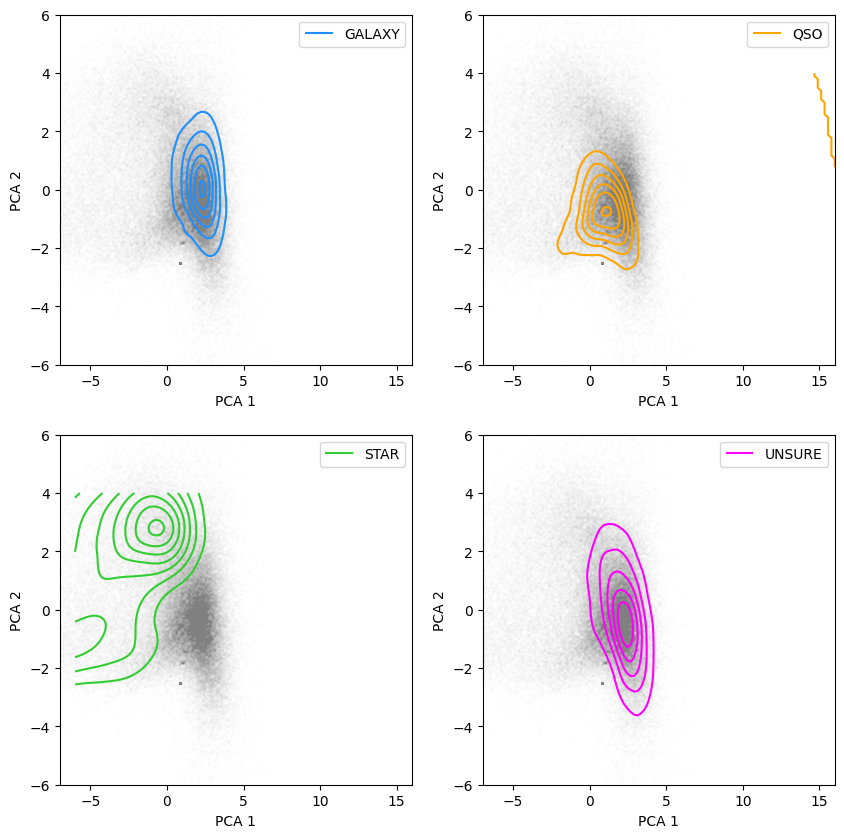

In [10]:
xmin, xmax = -6, 16
ymin, ymax = -6, 4

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

fig = plt.figure(figsize=(10, 10))
colors = ['dodgerblue', 'orange', 'limegreen', 'magenta']
for k, c in enumerate(classes):
    spots = tab['class'] == c
    
    plt.subplot(2, 2, k+1)
    plt.scatter(pca_sample[:, 0], pca_sample[:, 1], s=2, marker='.', color='grey', alpha=0.01)# bins='log', cmap='Greys', alpha=0.5) 
    
    values = np.vstack([pca_sample[:, 0][spots], pca_sample[:, 1][spots]])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cntr = plt.contour(xx, yy, f, colors=colors[k])
    h1, _ = cntr.legend_elements()
    
    plt.legend([h1[0]], [c])
    plt.xlim(-7, 16)
    plt.ylim(-6, 6)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
plt.show()


By inspection of the above panels, it looks like the different classes occupy unique regions of the simple PCA parameter space, with considerable overlap. As a next test, we will use tSNE to reduce dimensionality of the original dataset. In this example we will randomly subset the sample by 10% so that the tSNE algorithm runs quickly:

In [11]:
%%time
idx = np.random.choice(sample.shape[0], 10000)
tsne_sample = TSNE(n_components=2, init='pca', perplexity=10, learning_rate = 10).fit_transform(sample[idx])

CPU times: user 1min 6s, sys: 263 ms, total: 1min 6s
Wall time: 1min 6s


And similar to the PCA analysis, we will visualize the results:

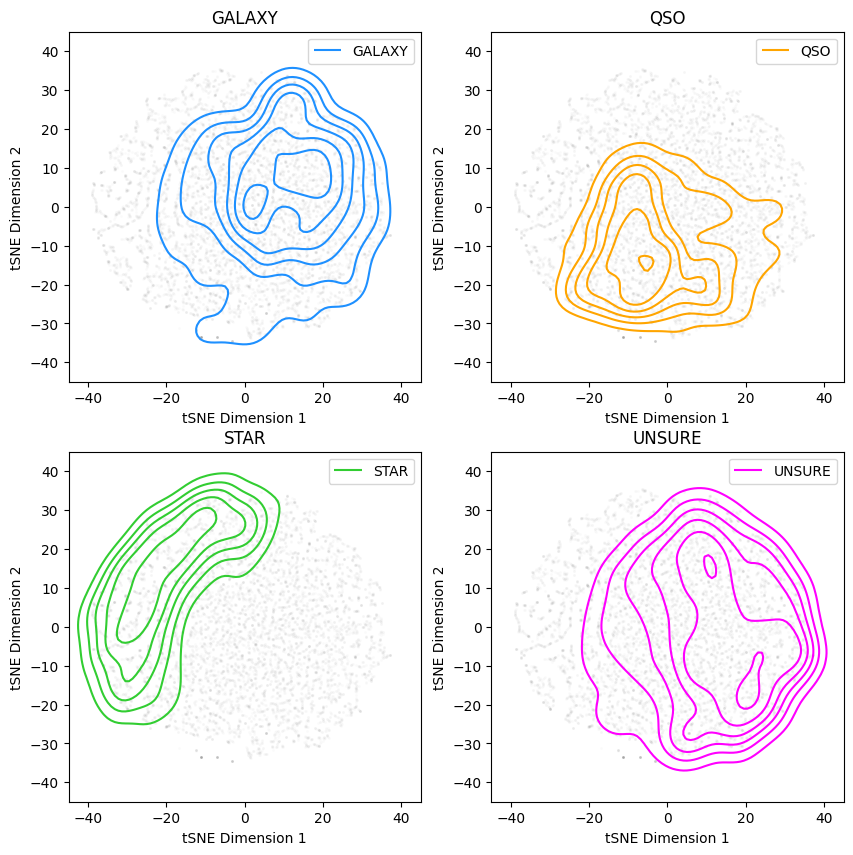

In [12]:
xmin, xmax = -45, 45
ymin, ymax = -45, 45

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

fig = plt.figure(figsize=(10, 10))

for k, c in enumerate(classes):
    spots = tab['class'][idx] == c
    plt.subplot(2, 2, k+1)
    plt.scatter(tsne_sample[:, 0], tsne_sample[:, 1], c='black', s=2, alpha=0.01)
    
    values = np.vstack([tsne_sample[:, 0][spots], tsne_sample[:, 1][spots]])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cntr = plt.contour(xx, yy, f, colors=colors[k]) 
    h1, _ = cntr.legend_elements()
    
    plt.legend([h1[0]], [c])
    plt.title(c)
    plt.xlabel('tSNE Dimension 1')
    plt.ylabel('tSNE Dimension 2')
plt.show()

Again, it looks like each class occupies a distinct region of tSNE parameter space, although it is a bit noisy with lots of overlap, especially between the "galaxy" and "unsure" classes.

### 4. Perform unsupervised classification

Next we will perform unsupervised classification with clustering. There are many choices of algorithms (see the [sklearn clustering documentation](https://scikit-learn.org/stable/modules/clustering.html)), and here we will apply the [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) algorithm, which requires that we specify the number of clusters a priori (4 in this case):

First, we will split the sample into training and test sets:

In [13]:
labels = tab['class_encode']

# Split off 30% of the data for testing
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(sample, labels, np.arange(len(labels)), test_size=0.3, random_state=42, shuffle=True)

In [14]:
kmeans = KMeans(init="k-means++", n_clusters=4)
kmeans.fit(X_train)

KMeans(n_clusters=4)

To visualize the results of the unsupervised clustering model, we will use the PCA representation of the **test** dataset and color the points by their labels assigned by k-means:

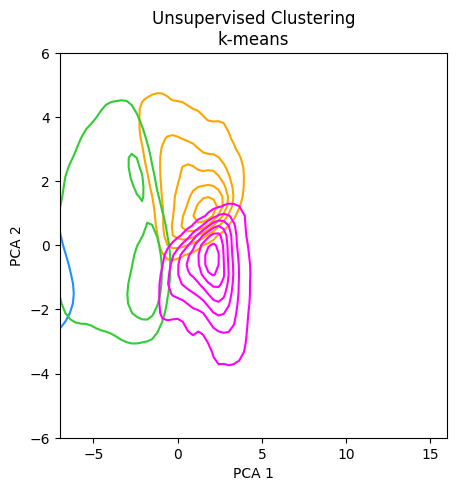

In [15]:
fig = plt.figure(figsize=(5, 5))

xmin, xmax = -10, 20
ymin, ymax = -10, 20

# Set up a grid for the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

pca_sample_test = pca_sample[idx_test]
kmeans_labels = kmeans.predict(X_test)

for k in range(4):
    pca_cluster = pca_sample_test[kmeans_labels == k]
    
    values = np.vstack([pca_cluster[:, 0], pca_cluster[:, 1]])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cntr = plt.contour(xx, yy, f, colors=colors[k], levels = np.linspace(0.01,0.12,6))

plt.title("Unsupervised Clustering\nk-means")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xlim(-7, 16)
plt.ylim(-6, 6)
plt.show()

When given the number of clusters, the k-means algorithm does a reasonable job of identifying distinct clusters. However, comparing these results with the true locations of the "galaxy", "qso", "star" and "unsure" classes in the PCA figure in Section 3, we can see that there is not a perfect correspondence between them. 

### 5. Perform supervised clustering

Given the class labels from the CNN analysis by [Beck et al. 2020](https://dx.doi.org/10.1093/mnras/staa2587), we will also apply supervised classification (i.e., training the algorithm using a sample of known answers). Here we'll use [stochastic gradient descent (SGD)](https://scikit-learn.org/stable/modules/sgd.html#sgd). 

Initialize the SGD classifier via sklearn. Here we will use the default parameters, but please see [the SGDClassifier() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) for more information on the available options. 

In [16]:
%%time
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

CPU times: user 566 ms, sys: 12 ms, total: 578 ms
Wall time: 561 ms


SGDClassifier()

To visualize the results of the supervised classification model, we will use the PCA representation of the **test** dataset and color the points by their labels assigned by SGD:

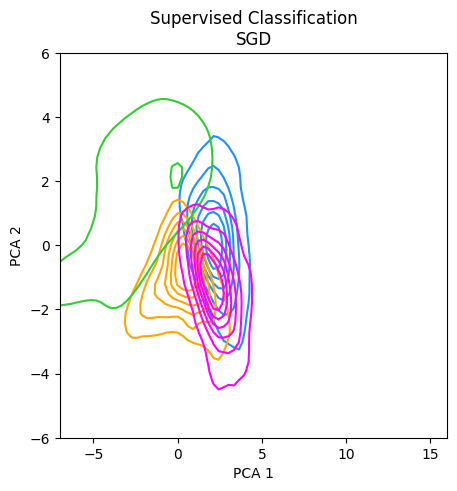

In [17]:
fig = plt.figure(figsize=(5, 5))

xmin, xmax = -10, 20
ymin, ymax = -10, 20

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

pca_sample_test = pca_sample[idx_test]
sgd_labels = sgd.predict(X_test)

for k in range(4):
    pca_cluster = pca_sample_test[sgd_labels == k]
    
    values = np.vstack([pca_cluster[:, 0], pca_cluster[:, 1]])
    kernel = st.gaussian_kde(values) 
    f = np.reshape(kernel(positions).T, xx.shape)
    cntr = plt.contour(xx, yy, f, colors=colors[k], levels = np.linspace(0.01,0.12,6))


plt.title("Supervised Classification\nSGD")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xlim(-7, 16)
plt.ylim(-6, 6)
plt.show() 

Unlike the unsupervised k-means classifier, the supervised SGD classifier appears to do a better job of identifying the true classifications (see Section 3), especially in the case of overlapping clusters in the PCA representation.

### 6. Assess the model performance

To visulize the performance of the supervised and unsupervised model results, we will use a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 


In [18]:
def plot_confusion_matrix(predictions, input_data, input_labels):
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1, 2, 3])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm)

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['Galaxy', 'QSO', 'Star', 'Unsure'])
    
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['Galaxy', 'QSO', 'Star', 'Unsure'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center", 
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

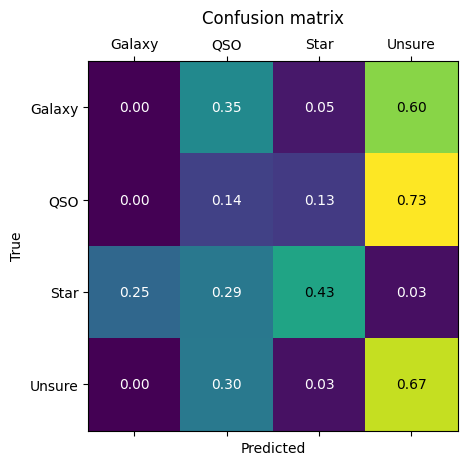

In [19]:
plot_confusion_matrix(kmeans_labels, X_test, y_test)

From the above plot, it is clear that the unsupervised clustering algorithm does an extremely poor job of identifying the correct classes!

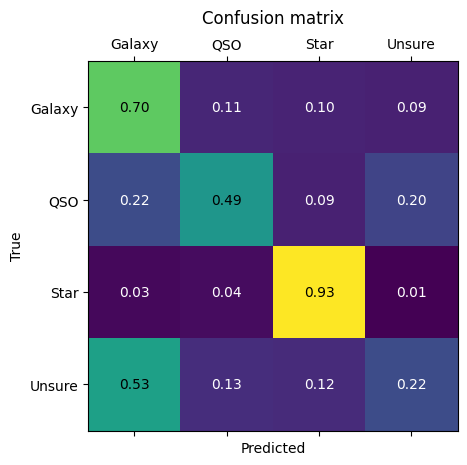

In [20]:
plot_confusion_matrix(sgd_labels, X_test, y_test)

Based on the above confusion matrix, the SGD classifier performs very well at identifying stars (~94% true positive) whereas it does not perform as well at distinguishing between the galaxy, QSO and unsure classes. 

## FAQs

- **How do I interpret these results?** The analysis above indicates that meaningful information about unresolved astronomical sources can be extracted from their simple measured fluxes and colors. In particular, the SGD classifier is able to identify stars well, even with the out-of-the-box parameters from sklearn. However, unsupervised k-means clustering is not able to successfully classify sources.


- **Can I improve the model by changing it?** Yes! In the k-means clustering and SGD classifier cases, there are many model parameters which can be tuned to improve the performance of the model. For example, in SGD, you can select the loss function (here we use the default, "hinge" which gives a linear [support vector machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).


- **Can I try a different model?  I think the results could be improved.** Yes! Check out the documentation at sklearn about classification. In particular, the [sklearn flowchart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) is a useful tool for figuring out which (of the many!) options might be useful. 


- **I want to test my model on my training data!** No. You will convince yourself that your results are much better than they actually are.  Always keep your training, validation, and testing sets completely separate!


### Appendix

**How to extract the subset of data analyzed here from the PS1 and PS1-STRM catalogs**

Instead of working with the full PS1-STRM catalog, we extracted a subset of 100,000 sources.

First, we downloaded a single [PS1-STRM](https://archive.stsci.edu/hlsp/ps1-strm) file (all sources with Declinations between 77 and 90) from MAST. We then randomly selected objects so that each of the four classes ("galaxy", "qso", "star", "unsure") had equal representation in a sample of 100,000 objects. We then saved the object IDs and unique internal object identifiers to a csv catalog file. 

Then, we uploaded this file to [MAST CasJobs](http://mastweb.stsci.edu/mcasjobs/) as "MyTable". We first cross-matched the object IDs we selected with the PS1-STRM catalog via the following query:



*select t.objid, s.class, s.prob_Galaxy, s.prob_Star, s.prob_QSO, s.z_phot, s.z_photErr* \
*into MyDB.ps1strm_fmo1* \
*from MyDB.MyTable t* \
*join catalogRecordRowStore s on s.objid=t.objid and s.uniquePspsOBid=t.uniquePspsOBid*


We then cross-matched this catalog with the full PS1 ForcedMeanObject table with the following query:



*select s.class, s.prob_Galaxy, s.prob_Star, s.prob_QSO, s.z_phot, s.z_photErr, fmo.* \
*into MyDB.ps1strm_fmo* \
*from MyDB.ps1strm_fmo1 s* \
*join ForcedMeanObject fmo on fmo.objid=s.objid*


## About this Notebook

**Author:**  
Claire Murray, Assistant Astronomer, cmurray1@stsci.edu  


**Info:**  
This notebook is based on the PS1-STRM catalog ([Beck et al. 2020](https://dx.doi.org/10.1093/mnras/staa2587)).

**Updated On:** 2022-5-25

## Citations

If you use this data set, `astropy`, or `sklearn` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.1633B/abstract)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `sklearn`](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)



[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 